<a href="https://colab.research.google.com/github/karthickrajas/Econometrics/blob/master/Portfolio_management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
# https://blog.quantinsti.com/portfolio-management-strategy-python/
# https://towardsdatascience.com/automating-portfolio-optimization-using-python-9f344b9380b9
# https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/
# https://evgenypogorelov.com/portfolio-rebalancing-python.html
# https://technical-analysis-library-in-python.readthedocs.io/en/latest/

! pip install yfinance
! pip install ta
! pip install PyPortfolioOpt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [60]:
import yfinance as yf
import pandas as pd
import numpy as np
import ta
from ta import add_all_ta_features

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.cla import CLA
from matplotlib.ticker import FuncFormatter
from tqdm import tqdm

In [26]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "AAPL MSFT AMZN GOOGL META TSLA NVDA BRK-B JNJ UNH",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "max",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        # interval = "1m",

        # Whether to ignore timezone when aligning ticker data from 
        # different timezones. Default is True. False may be useful for 
        # minute/hourly data.
        ignore_tz = False,

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        group_by = 'ticker',

        # adjust all OHLC automatically
        # (optional, default is False)
        auto_adjust = True,

        # download pre/post regular market hours data
        # (optional, default is False)
        prepost = True,

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True,

        # proxy URL scheme use use when downloading?
        # (optional, default is None)
        proxy = None
    )

data = data.loc['2008-01-01':,:]
data.index = pd.to_datetime(data.index.date)

[*********************100%***********************]  10 of 10 completed


In [50]:
df_ticker = data['BRK-B']
df_ticker_features = add_all_ta_features(
    df_ticker, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

In [56]:
data.columns.get_level_values(0).unique()

Index(['BRK-B', 'NVDA', 'MSFT', 'GOOGL', 'UNH', 'TSLA', 'AAPL', 'META', 'AMZN',
       'JNJ'],
      dtype='object')

In [61]:
auto_data =[]
for ticker in tqdm(data.columns.get_level_values(0).unique()):
  temp = add_all_ta_features(
    data[ticker], open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)
  temp = temp.drop(['Open','Close','High','Low','Volume'],axis=1)
  auto_data.append(temp)
  

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ta/wrapper.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high=df[high], low=df[low], close=df[close], volume=df[volume], fillna=fillna
/usr/local/lib/python3.7/dist-packages/ta/wrapper.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close=df[close], volume=df[volume], fillna=fillna
/usr/local/lib/python3.7/dist-packages/ta/wrapper.py:102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [65]:
df = pd.concat(auto_data,axis=0)

In [68]:
### Pytorch

import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm


In [67]:
df

,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,volume_sma_em,volume_vpt,volume_vwap,volume_mfi,volume_nvi,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
2008-01-02,-5.933375e+05,1780000.0,-0.333336,0.000000e+00,0.000000,0.000000,-683176.569473,92.580002,50.000000,1000.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,92.099998,-38.541639,0.000000,0.000000
2008-01-03,-6.055755e+05,2820000.0,-0.214743,9.360016e+05,31.057412,31.057412,-675878.283909,92.737354,100.000000,1009.772004,...,0.077897,0.015579,0.062318,-3.421739,-0.684348,-2.737391,92.436754,0.977200,0.972457,0.977200
2008-01-04,-8.812246e+05,1405000.0,-0.208081,3.980014e+05,-372.211944,-170.577266,-20267.223679,92.223692,42.842194,1009.772004,...,-0.035097,0.005444,-0.040541,-4.388047,-1.425088,-2.962959,91.874872,-2.150538,-2.173999,-1.194352
2008-01-07,-1.644771e+06,120000.0,-0.297966,-7.005558e+04,-369.432455,-236.862329,-62060.846592,91.544638,28.404487,984.916101,...,-0.318191,-0.059283,-0.258908,-5.772974,-2.294665,-3.478309,90.600282,-2.461536,-2.492338,-3.626489
2008-01-08,-1.939051e+06,-910000.0,-0.296038,-1.277332e+05,-190.291173,-225.219540,-36968.718398,91.063766,22.407338,979.811769,...,-0.577894,-0.163005,-0.414889,-8.178250,-3.471382,-4.706868,89.687768,-0.518250,-0.519598,-4.125945
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-20,1.118509e+09,707488100.0,-0.048157,-5.585862e+03,-0.871827,2.496811,-65433.360404,163.897217,49.473464,7132.187905,...,-0.040610,-0.249698,0.209089,-0.173472,-2.593201,2.419729,164.447669,0.255023,0.254699,286.609121
2022-10-21,1.124728e+09,715975000.0,-0.036022,4.359911e+06,108.556202,13.545622,199479.750464,164.301852,58.762182,7132.187905,...,0.165613,-0.166636,0.332249,1.206971,-1.833166,3.040138,165.260351,2.180368,2.156938,295.038623
2022-10-24,1.126254e+09,722830500.0,-0.030239,5.960196e+06,155.422314,19.637678,277286.261556,164.739982,59.144448,7228.151318,...,0.433872,-0.046535,0.480406,0.501439,-1.366245,1.867684,166.505526,1.345498,1.336526,300.353858
2022-10-25,1.130164e+09,717174100.0,0.039253,4.890573e+06,-38.920390,14.942761,83308.745446,165.043129,53.536277,7216.737577,...,0.624925,0.087757,0.537168,-1.395224,-1.372041,-0.023183,167.223457,-0.157907,-0.158032,299.721672


In [41]:
help(ta.add_trend_ta)

Help on function add_trend_ta in module ta.wrapper:

add_trend_ta(df: pandas.core.frame.DataFrame, high: str, low: str, close: str, fillna: bool = False, colprefix: str = '', vectorized: bool = False) -> pandas.core.frame.DataFrame
    Add trend technical analysis features to dataframe.
    
    Args:
        df (pandas.core.frame.DataFrame): Dataframe base.
        high (str): Name of 'high' column.
        low (str): Name of 'low' column.
        close (str): Name of 'close' column.
        fillna(bool): if True, fill nan values.
        colprefix(str): Prefix column names inserted
        vectorized(bool): if True, use only vectorized functions indicators
    
    Returns:
        pandas.core.frame.DataFrame: Dataframe with new features.



In [35]:
df_ticker_features.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'volume_adi', 'volume_obv',
       'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em', 'volume_vpt',
       'volume_vwap', 'volume_mfi', 'volume_nvi', 'volatility_bbm',
       'volatility_bbh', 'volatility_bbl', 'volatility_bbw', 'volatility_bbp',
       'volatility_bbhi', 'volatility_bbli', 'volatility_kcc',
       'volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base

In [ ]:
ls_stocks = "AAPL MSFT AMZN GOOGL META TSLA NVDA BRK-B JNJ UNH".split(' ')
",".join(ls_stocks)

'AAPL,MSFT,AMZN,GOOGL,META,TSLA,NVDA,BRK-B,JNJ,UNH'

In [46]:
cls_price = data.loc[:,data.columns.get_level_values(1)=='Close']
cls_price.columns = cls_price.columns.get_level_values(0)
cls_price 

,BRK-B,NVDA,MSFT,GOOGL,UNH,TSLA,AAPL,META,AMZN,JNJ
2008-01-02,92.099998,7.575688,25.928684,17.146896,46.735241,NaN,5.941449,NaN,4.812500,42.707218
2008-01-03,93.000000,7.516018,26.039122,17.150400,46.949665,NaN,5.944195,NaN,4.760500,42.720173
2008-01-04,91.000000,6.884903,25.310282,16.441441,46.182697,NaN,5.490444,NaN,4.439500,42.661858
2008-01-07,88.760002,6.173463,25.479605,16.247498,46.908440,NaN,5.416954,NaN,4.441000,43.322777
2008-01-08,88.300003,6.304275,24.625626,15.807808,46.355873,NaN,5.222097,NaN,4.394000,43.374580
...,...,...,...,...,...,...,...,...,...,...
2022-10-20,273.529999,121.940002,236.149994,99.970001,520.880005,207.279999,143.389999,131.529999,115.250000,165.110001
2022-10-21,282.510010,124.660004,242.119995,101.129997,533.729980,214.440002,147.270004,130.009995,119.320000,168.710007
2022-10-24,287.480011,125.989998,247.250000,102.519997,541.599976,211.250000,149.449997,129.720001,119.820000,170.979996
2022-10-25,289.239990,132.610001,250.660004,104.480003,540.219971,222.419998,152.339996,137.509995,120.599998,170.710007


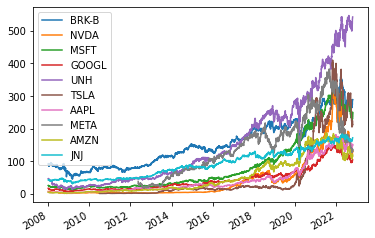

In [47]:
cls_price.plot()

In [ ]:
def _get_indicator_data(data):
    """
    Function that uses the finta API to calculate technical indicators used as the features
    :return:
    """

    for ticker in data.columns:

      # Also calculate moving averages for features
      data['ema50'+ticker] = data[ticker] / data[ticker].ewm(50).mean()
      data['ema21'+ticker] = data[ticker] / data[ticker].ewm(21).mean()
      data['ema15'+ticker] = data[ticker] / data[ticker].ewm(14).mean()
      data['ema5'+ticker] = data[ticker] / data[ticker].ewm(5).mean()
    
    return data

In [ ]:
_get_indicator_data(cls_price)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

,BRK-B,NVDA,MSFT,UNH,AAPL,TSLA,AMZN,GOOGL,META,JNJ,...,ema15GOOGL,ema5GOOGL,ema50META,ema21META,ema15META,ema5META,ema50JNJ,ema21JNJ,ema15JNJ,ema5JNJ
2008-01-02,92.099998,7.575688,25.928680,46.735233,5.941450,NaN,4.812500,17.146896,NaN,42.707218,...,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000
2008-01-03,93.000000,7.516020,26.039108,46.949669,5.944195,NaN,4.760500,17.150400,NaN,42.720173,...,1.000099,1.000093,NaN,NaN,NaN,NaN,1.000150,1.000148,1.000146,1.000138
2008-01-04,91.000000,6.884902,25.310280,46.182701,5.490443,NaN,4.439500,16.441441,NaN,42.661842,...,0.973067,0.974656,NaN,NaN,NaN,NaN,0.999197,0.999207,0.999215,0.999258
2008-01-07,88.760002,6.173463,25.479614,46.908443,5.416955,NaN,4.441000,16.247498,NaN,43.322773,...,0.971909,0.974718,NaN,NaN,NaN,NaN,1.010857,1.010713,1.010590,1.009947
2008-01-08,88.300003,6.304276,24.625624,46.355892,5.222098,NaN,4.394000,15.807808,NaN,43.374607,...,0.957508,0.962191,NaN,NaN,NaN,NaN,1.009533,1.009287,1.009079,1.008022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-19,278.339996,120.510002,236.479996,520.320007,143.860001,222.039993,115.070000,99.629997,133.229996,164.690002,...,0.982633,1.004048,0.811525,0.916060,0.949373,1.000381,0.981790,0.996159,1.000274,1.001549
2022-10-20,273.529999,121.940002,236.149994,520.880005,143.389999,207.279999,115.250000,99.970001,131.529999,165.110001,...,0.986909,1.006221,0.804306,0.908320,0.941196,0.989659,0.984597,0.998758,1.002636,1.003417
2022-10-21,282.510010,124.660004,242.119995,533.729980,147.270004,214.440002,119.320000,101.129997,130.009995,168.710007,...,0.998469,1.014870,0.798219,0.902012,0.934661,0.981785,1.005945,1.019583,1.022827,1.020990
2022-10-24,287.480011,125.989998,247.250000,541.599976,149.449997,211.250000,119.820000,102.519997,129.720001,170.979996,...,1.011371,1.023901,0.799630,0.904110,0.936787,0.982938,1.019091,1.031740,1.034066,1.028773


In [ ]:
mu = expected_returns.mean_historical_return(cls_price)
cov = risk_models.sample_cov(cls_price)
ef = EfficientFrontier(mu, cov)
weights = ef.max_sharpe()
ef.portfolio_performance(verbose=True)

Expected annual return: 29.8%
Annual volatility: 28.2%
Sharpe Ratio: 0.99


(0.29787363674545125, 0.2818897281965884, 0.9857529698693512)

In [ ]:
log_returns = cls_price.pct_change().apply(lambda x: np.log(1+x))
cov_matrix = log_returns.cov()
corr_matrix = log_returns.corr()


In [ ]:
cls_price.columns

Index(['BRK-B', 'NVDA', 'MSFT', 'UNH', 'AAPL', 'TSLA', 'AMZN', 'GOOGL', 'META',
       'JNJ'],
      dtype='object')

In [ ]:
w = {i:weights[i] for i in weights}
port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
(port_var*250)**0.5

0.2807003393814701

In [ ]:
rebalancing_dates = data.resample('M').apply(lambda x: x[-1]).index
rebalancing_dates[0]

Timestamp('2008-01-31 00:00:00', freq='M')

In [ ]:
data.loc['2008-01-31'].pct_change()
np.log(data.loc['2008-01-31']) - np.log(data.loc['2008-01-31'].shift(1))

TSLA   Open            NaN
       High            NaN
       Low             NaN
       Close           NaN
       Volume          NaN
AMZN   Open            NaN
       High       0.135000
       Low       -0.136016
       Close      0.121070
       Volume    19.212663
NVDA   Open     -18.837281
       High       0.016503
       Low       -0.049929
       Close      0.031395
       Volume    16.160382
UNH    Open     -14.170180
       High       0.020754
       Low       -0.035846
       Close      0.030354
       Volume    12.203259
JNJ    Open     -12.248245
       High       0.024432
       Low       -0.026698
       Close      0.022746
       Volume    13.161574
MSFT   Open     -13.716350
       High       0.025678
       Low       -0.031650
       Close      0.027365
       Volume    15.278407
GOOGL  Open     -15.854600
       High       0.061152
       Low       -0.069947
       Close      0.054647
       Volume    17.555116
BRK-B  Open     -15.657403
       High       0.000000
 

In [ ]:
def get_closing_values(data :pd.DataFrame, 
                       date: str
                       ) -> pd.DataFrame:
                       limited_data = data.loc[ date,:]
                       limited_data = limited_data.loc[limited_data.index.get_level_values(1)=='Close',:]
                       limited_data.index = [i[0] for i in limited_data.index]
                       return pd.DataFrame(limited_data.loc[ls_stocks])

In [ ]:
ls_stocks
port_wt = {i: round(1/(1+len(ls_stocks)),3) for i in ls_stocks}
port_wt = pd.DataFrame({i:[j] for (i,j) in port_wt.items()}).T 

In [ ]:
port_wt.T 

,AAPL,MSFT,AMZN,GOOGL,META,TSLA,NVDA,BRK-B,JNJ,UNH
0,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091,0.091


In [ ]:
check = get_closing_values(data, '2016-01-21')
check.T.reset_index(drop=True)

,AAPL,MSFT,AMZN,GOOGL,META,TSLA,NVDA,BRK-B,JNJ,UNH
0,22.076778,45.385151,28.750999,36.3335,94.160004,13.331333,6.789661,125.620003,80.192268,102.458839


In [ ]:
tot_value = port_wt.T   * check.T.reset_index(drop=True)

In [ ]:
tot_value

NameError: ignored